In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_URL = "https://raw.githubusercontent.com/marcopeix/FoundationModelsForTimeSeriesForecasting/refs/heads/main/data/Walmart.csv"

df = pd.read_csv(DATA_URL)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


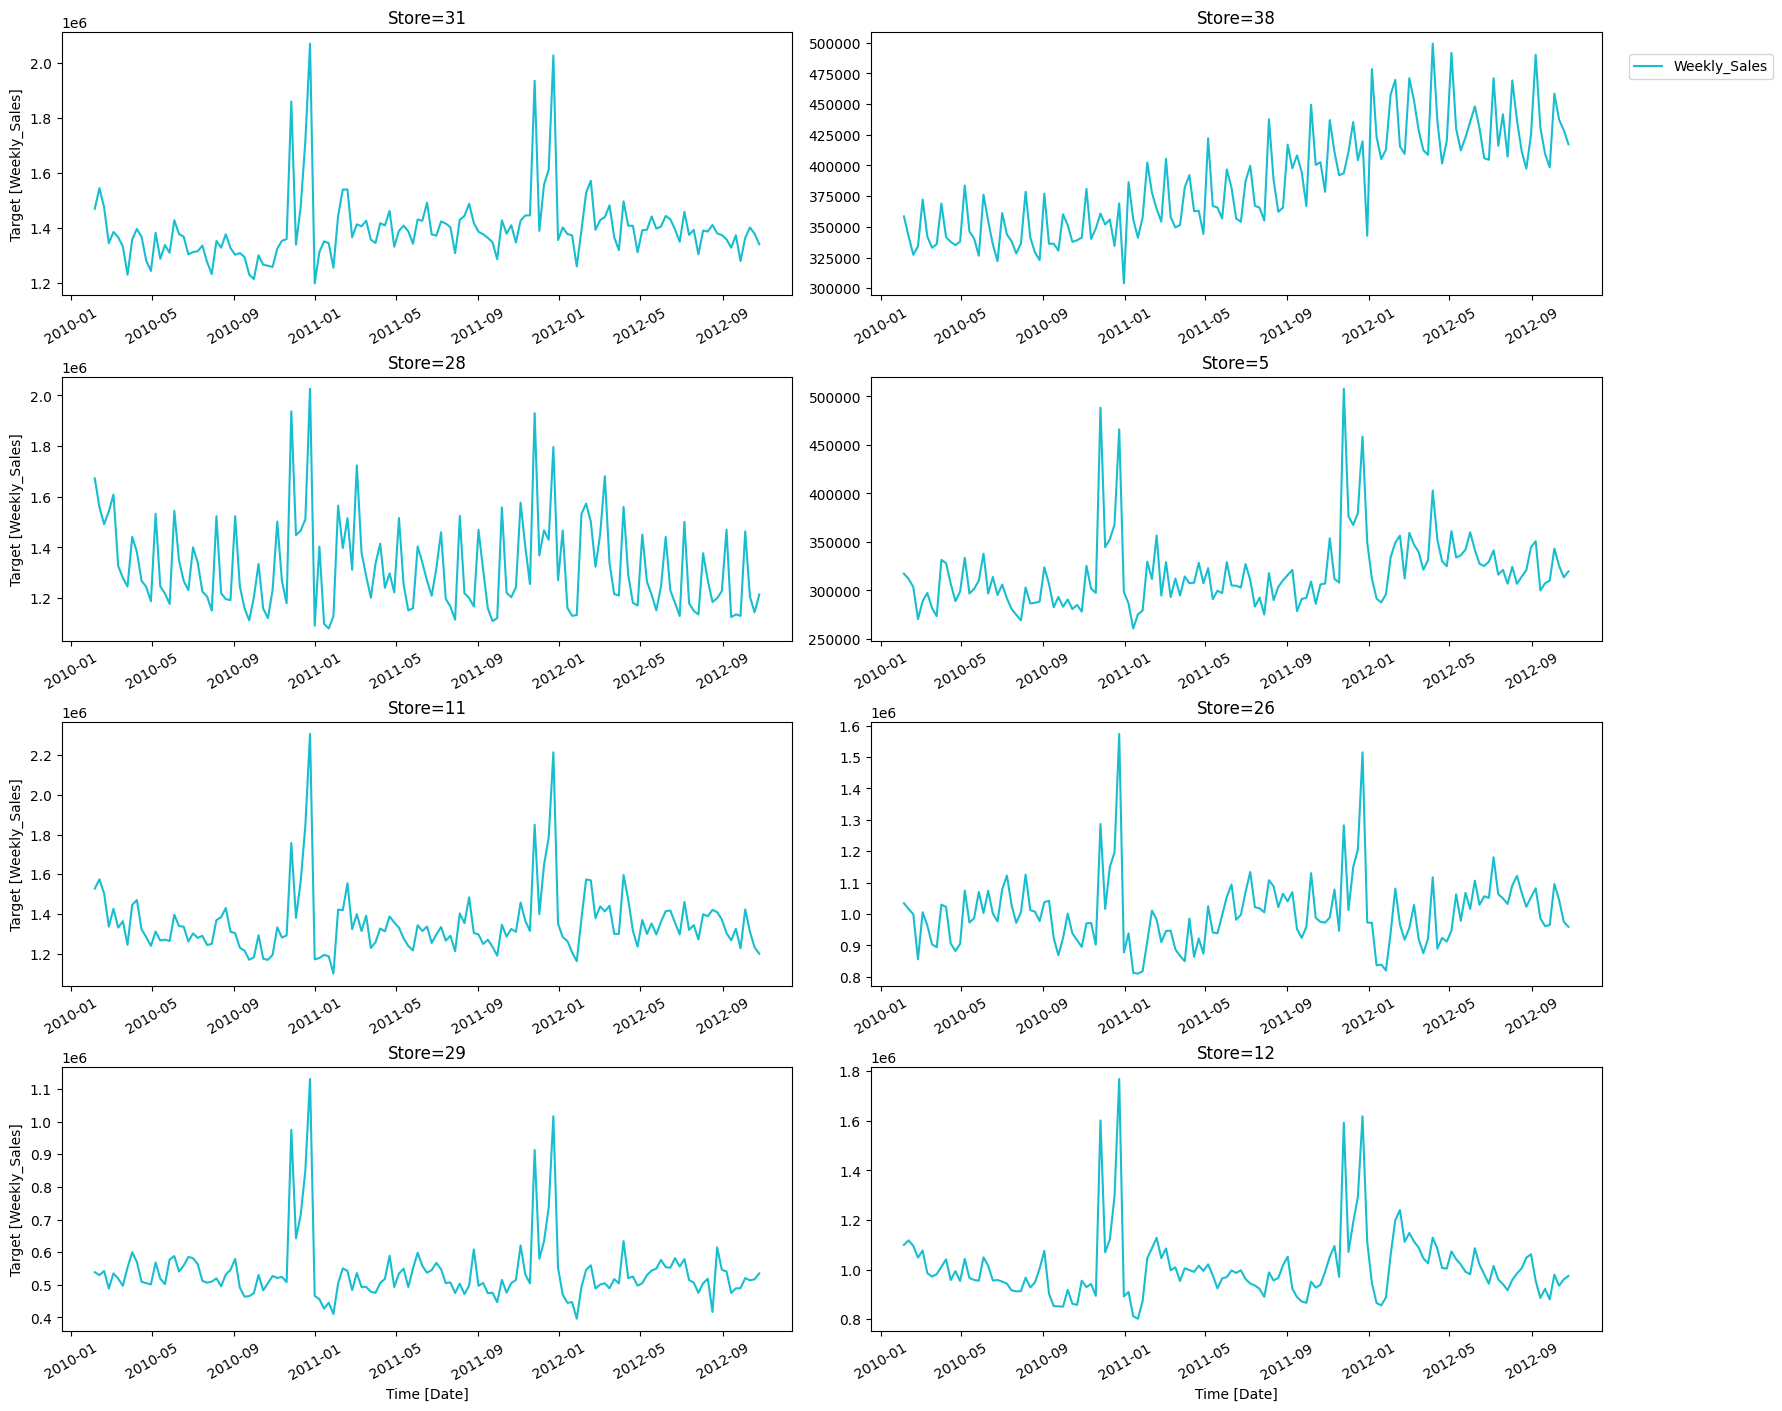

In [3]:
plot_series(
    df=df,
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
)

## Zero-shot forecasting

Make sure to `pip install -U nixtla` to access the model's client.

In [4]:
from dotenv import load_dotenv
from nixtla import NixtlaClient

In [7]:
load_dotenv()
client = NixtlaClient()

In [8]:
HORIZON = 13

In [9]:
fcsts_df = client.forecast(
    df=df,
    h=HORIZON,
    freq="W-FRI",
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    level=[80],
    model="timegpt-2"
)
fcsts_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Store,Date,TimeGPT,TimeGPT-hi-80,TimeGPT-lo-80
0,1,2012-11-02,1589086.1,1721000.4,1487427.5
1,1,2012-11-09,1639316.2,1786696.2,1542985.5
2,1,2012-11-16,1641033.0,1777912.5,1517581.9
3,1,2012-11-23,1730851.1,1944602.4,1588313.9
4,1,2012-11-30,1644781.1,1820778.8,1500224.8


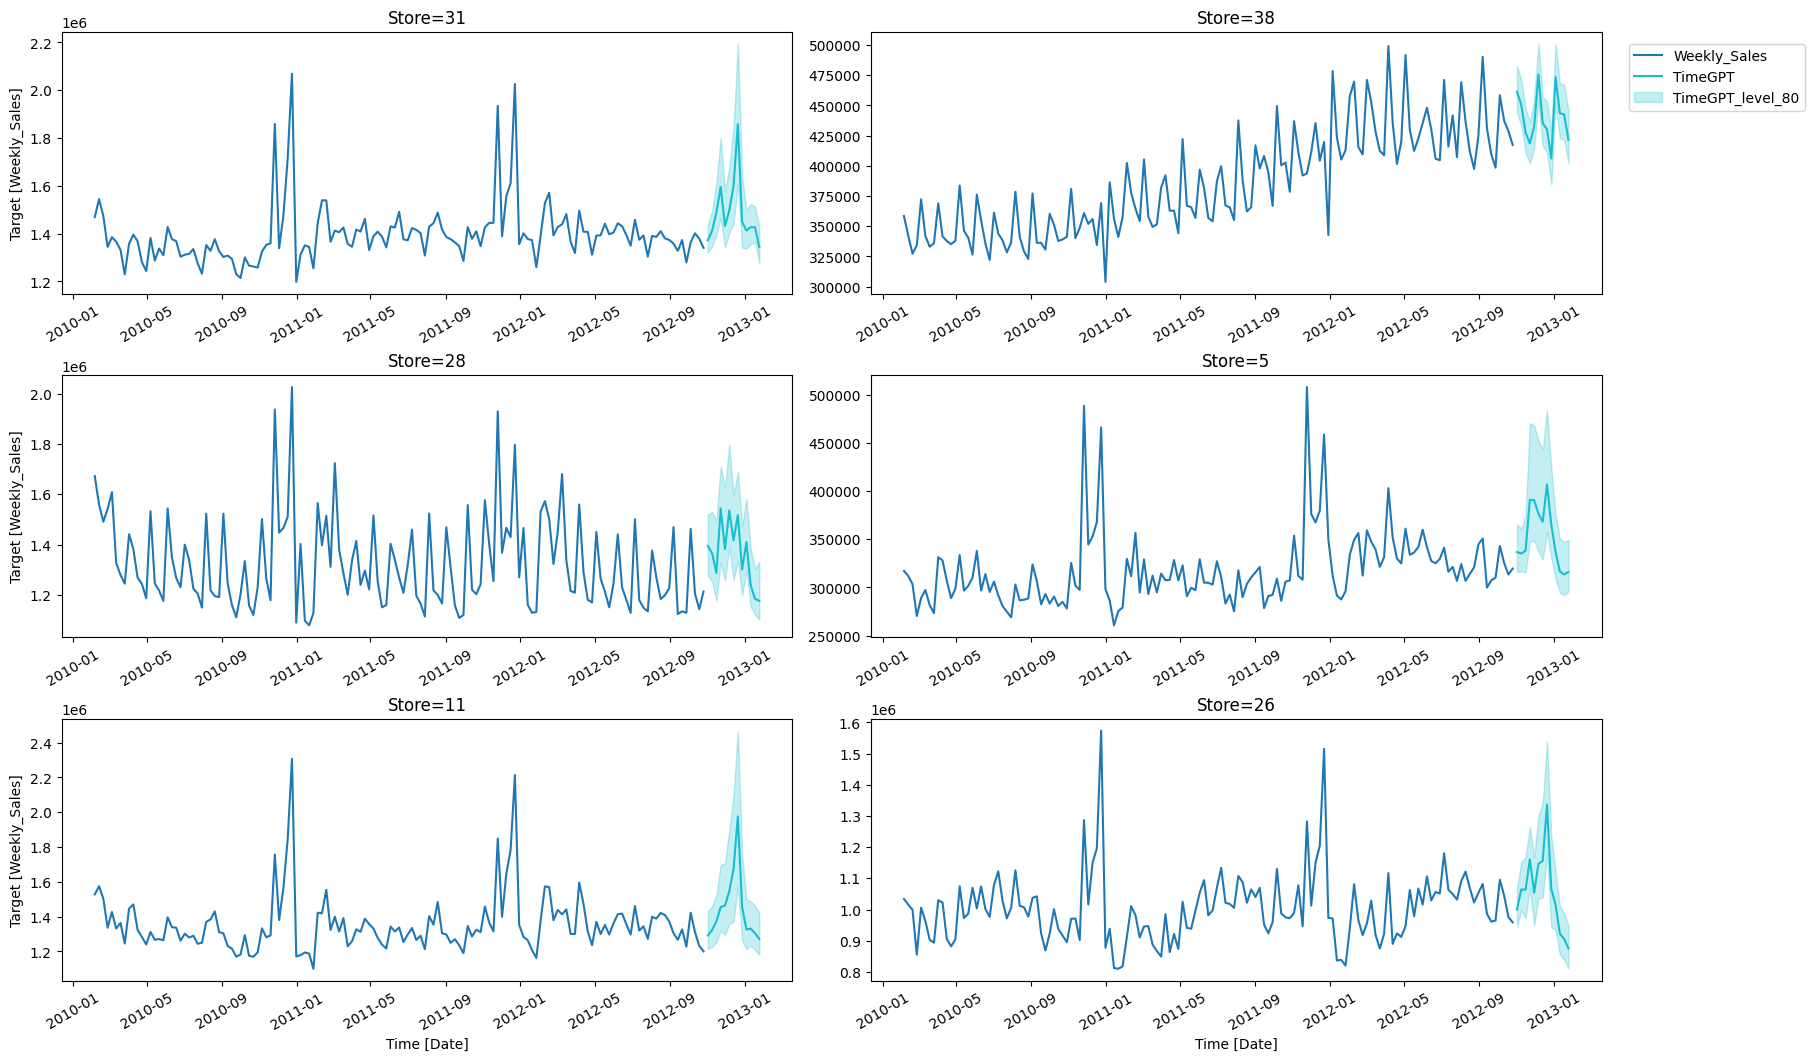

In [10]:
plot_series(
    df=df,
    forecasts_df=fcsts_df,
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    level=[80],
    max_ids=6,
)

## Cross-validation

In [11]:
from functools import reduce

In [14]:
base_cols = ["Store", "Date", "Weekly_Sales"]
models = ["timegpt-2-mini", "timegpt-2", "timegpt-2-pro", "timegpt-2.1"]

cv_results = []

for model in models:
    cv_df = client.cross_validation(
        df=df[base_cols],
        h=HORIZON,
        n_windows=3,
        step_size=HORIZON,
        id_col="Store",
        time_col="Date",
        target_col="Weekly_Sales",
        level=[80],
        model=model
    )
    cv_df = cv_df.rename(columns={
        "TimeGPT": model,
        "TimeGPT-lo-80": f"{model}-lo-80",
        "TimeGPT-hi-80": f"{model}-hi-80"
    })

    if len(cv_results) == 0:
        cv_results.append(cv_df)
    else:
        cv_results.append(cv_df.drop(columns=["Weekly_Sales"]))
final_cv_df = reduce(
    lambda left, right: left.merge(right, on=["Store", "Date", "cutoff"], how="left"),
    cv_results
)
final_cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client

,Store,Date,cutoff,Weekly_Sales,timegpt-2-mini,timegpt-2-mini-hi-80,timegpt-2-mini-lo-80,timegpt-2,timegpt-2-hi-80,timegpt-2-lo-80,timegpt-2-pro,timegpt-2-pro-hi-80,timegpt-2-pro-lo-80,timegpt-2.1,timegpt-2.1-hi-80,timegpt-2.1-lo-80
0,1,2012-02-03,2012-01-27,1636339.65,1467339.0,1665420.4,1269257.6,1473986.9,1580661.2,1384750.6,1470093.1,1575374.5,1388038.1,1601388.5,1722444.1,1440883.5
1,1,2012-02-10,2012-01-27,1802477.43,1538662.4,1625483.8,1451841.0,1527631.8,1650752.1,1431154.9,1533979.6,1653226.9,1435377.1,1638317.2,1783066.4,1515268.6
2,1,2012-02-17,2012-01-27,1819870.00,1551574.6,1610431.9,1492717.4,1519486.8,1640291.9,1422074.9,1515236.5,1638987.4,1422787.2,1615126.2,1731664.6,1493493.5
3,1,2012-02-24,2012-01-27,1539387.83,1551116.2,1912397.1,1189835.4,1468750.4,1591286.9,1363808.1,1477609.2,1592489.1,1377588.5,1506946.4,1647318.6,1400913.5
4,1,2012-03-02,2012-01-27,1688420.76,1550435.0,1626666.1,1474203.9,1515207.1,1652410.2,1412319.9,1498372.4,1636314.8,1410941.8,1585967.2,1704226.2,1455201.8


In [16]:
eval_df = evaluate(
    final_cv_df.drop(columns=["cutoff"]),
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    level=[80],
    agg_fn="mean"
)
eval_df

,metric,timegpt-2-mini,timegpt-2,timegpt-2-pro,timegpt-2.1
0,mae,61917.313983,50201.923214,52552.436479,42959.271459
1,smape,0.029447,0.023613,0.024511,0.020529


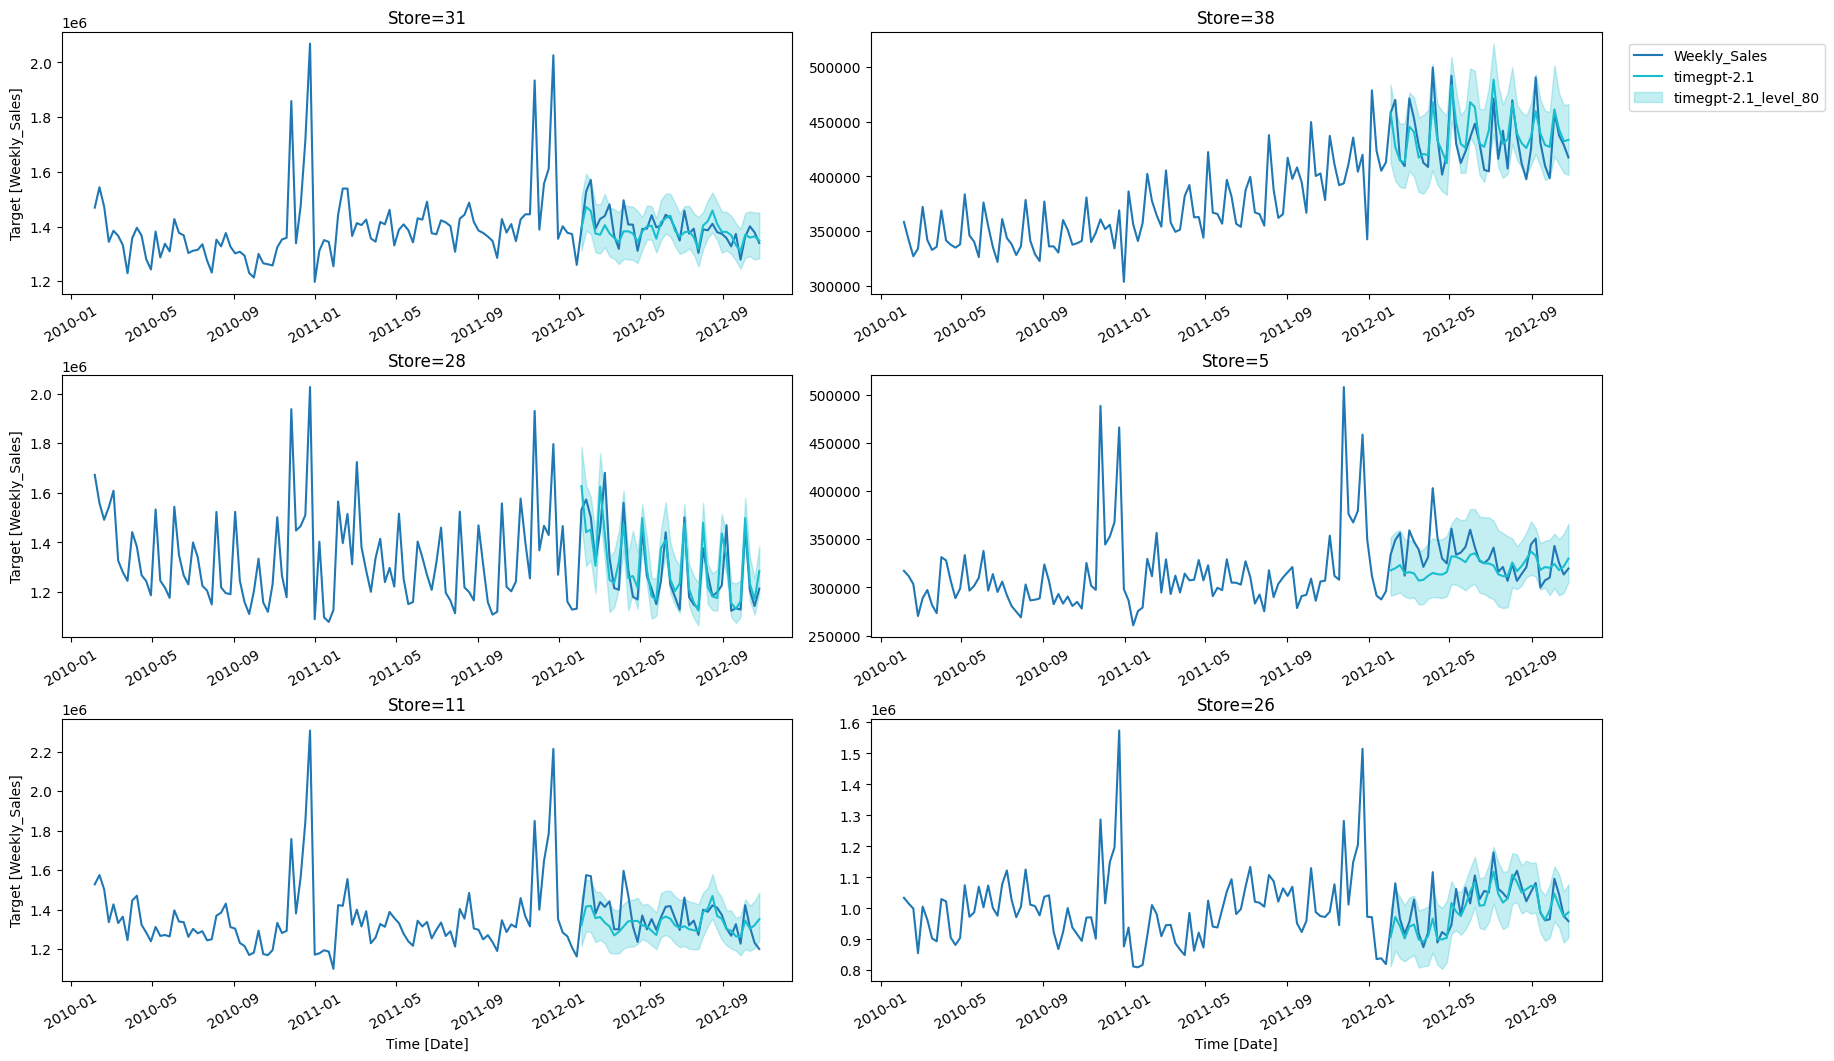

In [18]:
plot_series(
    df=df,
    forecasts_df=cv_df[["Store", "Date", "timegpt-2.1", "timegpt-2.1-lo-80", "timegpt-2.1-hi-80"]],
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    level=[80],
    max_ids=6,
)

## Exogenous features

In [19]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [20]:
exog_cv_df = client.cross_validation(
    df=df,
    h=HORIZON,
    n_windows=3,
    step_size=HORIZON,
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    hist_exog_list=["Temperature", "Fuel_Price", "CPI", "Unemployment"],
    model="timegpt-2.1"
)
exog_cv_df = exog_cv_df.rename(columns={"TimeGPT": "timegpt-2.1"})

eval_df = evaluate(
    exog_cv_df.drop(columns=["cutoff"]),
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
eval_df

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag']
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,metric,timegpt-2.1
0,mae,40316.640245
1,smape,0.019299


In [21]:
exog_cv_df = client.cross_validation(
    df=df.drop(columns=["Temperature", "Fuel_Price", "CPI", "Unemployment"]),
    h=HORIZON,
    n_windows=3,
    step_size=HORIZON,
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    model="timegpt-2.1"
)
exog_cv_df = exog_cv_df.rename(columns={"TimeGPT": "timegpt-2.1"})

eval_df = evaluate(
    exog_cv_df.drop(columns=["cutoff"]),
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
eval_df

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,metric,timegpt-2.1
0,mae,42336.864838
1,smape,0.020050


### Explainability

In [22]:
test_df = df.groupby("Store").tail(13)
input_df = df.drop(test_df.index)
X_df = test_df[["Store", "Date", "Holiday_Flag"]]

In [23]:
exog_fcsts_df = client.forecast(
    df=input_df,
    X_df=X_df,
    h=HORIZON,
    freq="W-FRI",
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    model="timegpt-2.1",
    feature_contributions=True
)
exog_fcsts_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Store,Date,TimeGPT
0,1,2012-08-03,1648891.5
1,1,2012-08-10,1595781.5
2,1,2012-08-17,1602106.0
3,1,2012-08-24,1553093.2
4,1,2012-08-31,1626065.4


In [24]:
shap_df = client.feature_contributions
shap_df.head()

,Store,Date,TimeGPT,Holiday_Flag,base_value
0,1,2012-08-03,1648891.5,-40122.75,1689014.2
1,1,2012-08-10,1595781.5,-20461.75,1616243.2
2,1,2012-08-17,1602106.0,-28043.25,1630149.2
3,1,2012-08-24,1553093.2,-8474.75,1561568.0
4,1,2012-08-31,1626065.4,-17089.00,1643154.4


In [26]:
test_df.head(13)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
130,1,2012-08-03,1631135.79,0,86.11,3.417,221.949864,6.908
131,1,2012-08-10,1592409.97,0,85.05,3.494,221.958433,6.908
132,1,2012-08-17,1597868.05,0,84.85,3.571,222.038411,6.908
133,1,2012-08-24,1494122.38,0,77.66,3.620,222.171946,6.908
134,1,2012-08-31,1582083.40,0,80.49,3.638,222.305480,6.908
135,1,2012-09-07,1661767.33,1,83.96,3.730,222.439015,6.908
136,1,2012-09-14,1517428.87,0,74.97,3.717,222.582019,6.908
137,1,2012-09-21,1506126.06,0,69.87,3.721,222.781839,6.908
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573


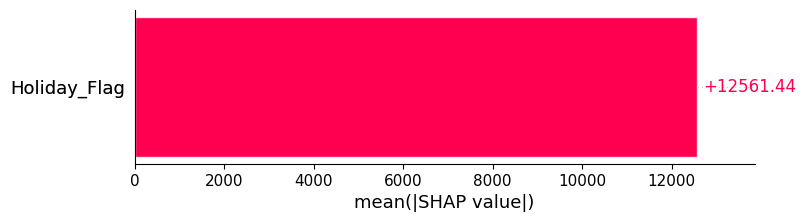

In [29]:
import shap

shap_cols = shap_df.columns.difference(["Store", "Date", "Weekly_Sales", "TimeGPT", "base_value"])

shap_obj = shap.Explanation(
    values=shap_df[shap_cols].values,
    base_values=shap_df["base_value"].values,
    feature_names=shap_cols
)

shap.plots.bar(shap_obj, show=False)
plt.show()

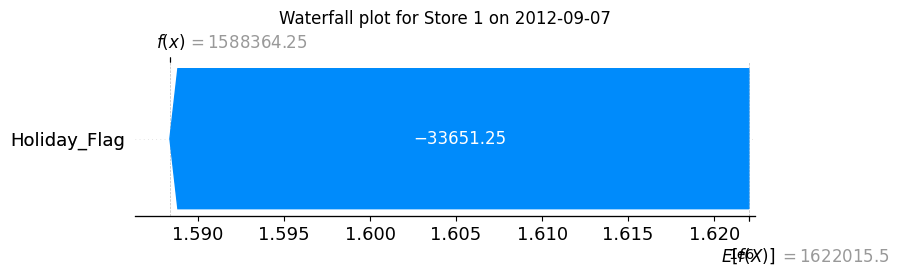

In [42]:
selected_ds = "2012-09-07"
selected_store = 1

filtered_shap_df = shap_df[(shap_df["Date"] == selected_ds) & (shap_df["Store"] == selected_store)]

shap_obj = shap.Explanation(
    values=filtered_shap_df[shap_cols].values.flatten(),
    base_values=filtered_shap_df["base_value"].values[0],
    feature_names=shap_cols
)

shap.plots.waterfall(shap_obj, show=False)
plt.title(f"Waterfall plot for Store {selected_store} on {selected_ds}")
plt.show()

## Multivariate forecasting

In [43]:
mv_cv_df = client.cross_validation(
    df=df,
    h=HORIZON,
    n_windows=3,
    step_size=HORIZON,
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    hist_exog_list=["Temperature", "Fuel_Price", "CPI", "Unemployment"],
    model="timegpt-2.1",
    multivariate=True,
)
mv_cv_df = mv_cv_df.rename(columns={"TimeGPT": "timegpt-2.1"})

eval_df = evaluate(
    mv_cv_df.drop(columns=["cutoff"]),
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
eval_df

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag']
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,metric,timegpt-2.1
0,mae,40070.959601
1,smape,0.019123


## Fine-tuning

In [44]:
ft_cv_df = client.cross_validation(
    df=df,
    h=HORIZON,
    n_windows=3,
    step_size=HORIZON,
    id_col="Store",
    time_col="Date",
    target_col="Weekly_Sales",
    hist_exog_list=["Temperature", "Fuel_Price", "CPI", "Unemployment"],
    model="timegpt-2.1",
    multivariate=True,
    finetune_steps=10,
    finetune_loss="mae",
)
ft_cv_df = ft_cv_df.rename(columns={"TimeGPT": "timegpt-2.1"})

eval_df = evaluate(
    ft_cv_df.drop(columns=["cutoff"]),
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col="Date",
    agg_fn="mean"
)
eval_df

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag']
INFO:nixtla.nixtla_client:Using historical exogenous features: ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,metric,timegpt-2.1
0,mae,37814.485031
1,smape,0.018012
